In [29]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 32 cm example
## 2019-11-28 Parameterized Qbed

This is an update of the notebook published under [prototyping/2019-05-30_Parameterized_qbed.ipynb]. This is a model which makes some assumptions regarding Qsb, in that the profile of Qsb at equilibrium is in phase with the profile of the dune. In this way, the model collapses into a convection equation. Afterwards we present a modified model which allows the dune to decay at a specific rate based on the A3DOWN experiment of Weibe.



dx: 0.8682235195996664 cm
nx 1200


Text(0, 0.5, 'z (m)')

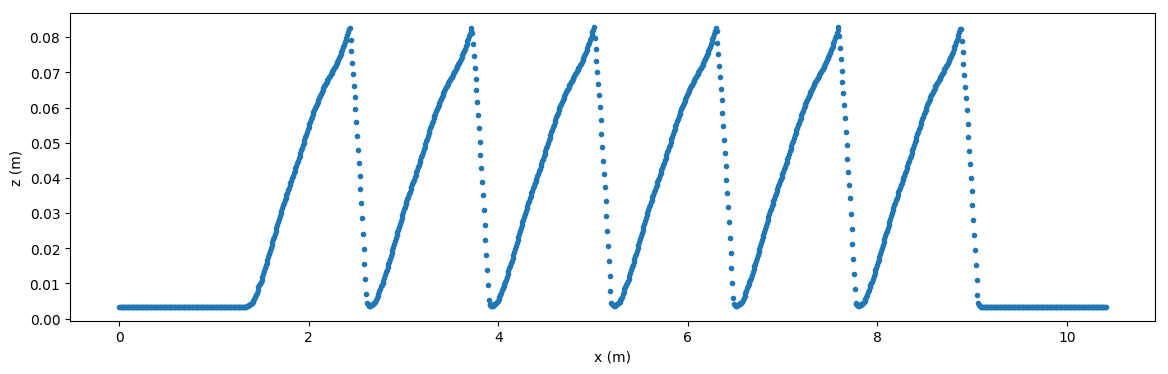

In [30]:
filepath = '../Paper_3/dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## 32 cm Flow Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]

$
q_{sb} = \frac{z}{\Delta}q_{sb}^{max}
$

This equation basically says that the bed load is equal to the local local elevation multiplied by the peak bedload. the $q_{sb}^{max}$ is calibrated to match the migration rate of the dune.

Initalized
 Starting simulation....
Number of time steps: 10.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 0.16666666666666666 mins - uavg: 0.0 - Elevation 0.032884586391437313
Courant number: max 0.061422991056637934, mean0.023044230382846767
Time step: 0.3333333333333333 mins - uavg: 0.0 - Elevation 0.032884586391437313
Courant number: max 0.06165939344600803, mean0.023053429329603022
Time step: 0.5 mins - uavg: 0.0 - Elevation 0.03288458639143731
Courant number: max 0.06183865092470225, mean0.023062732378109928
Time step: 0.6666666666666666 mins - uavg: 0.0 - Elevation 0.032884586391437313
Courant number: max 0.06209366159507771, mean0.023072125517108185
Time step: 0.8333333333333334 mins - uavg: 0.0 - Elevation 0.032884586391441685
Courant number: max 0.06228945074498466, mean0.023081581099085216
Time step: 1.0 mins - uavg

Text(0, 0.5, 'z (m)')

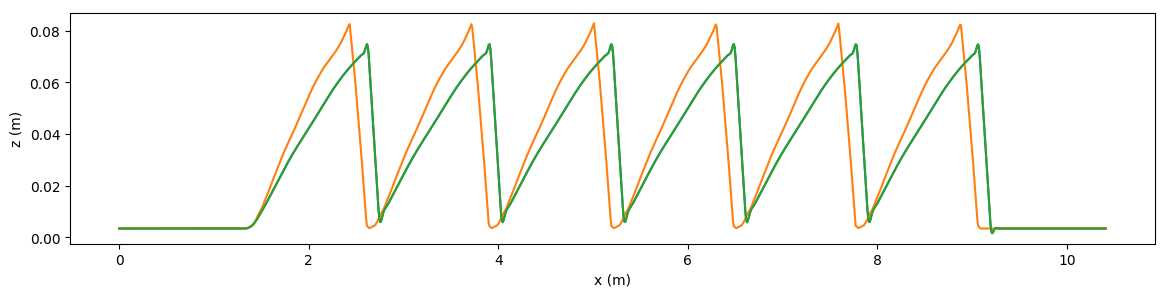

In [31]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 600       # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 10

run_name = 'dune_5_Parameterized_{0}_v01'.format('32cm')

model = sdmodels.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
#morph_model = sdmodels.MacCormackModel()
morph_model = sdmodels.TVD2ndWenoModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = True, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)
#-------------------------
# Set the bedload formula
#-------------------------
qsbmax = 0.0000127

#qsbmax = 0.0000254
delta = 0.079
zoffset = 0.0034
qsbmodel = sdmodels.EquilibriumBedloadModel(qsbmax, delta, zoffset)


#-------------------------
# Set the bedload formula
#-------------------------
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
c = 1.
d = 0.05
qsbmodel = sdmodels.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)


model.set_bedload_model(qsbmodel)

xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 3))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [30]:
run_name = 'dune_5_Parameterized_v01'.format('32m','357mm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))

from scipy.signal import savgol_filter
heights = [post.calculate_wave_height(verts[t,:,1],dx) for t in range((verts.shape[0]))]
savgol_filter(heights, int(len(heights)/2), 2)



array([0.07918572, 0.07918515, 0.07918459, ..., 0.07982073, 0.07982163,
       0.07982254])

ValueError: x must be strictly increasing

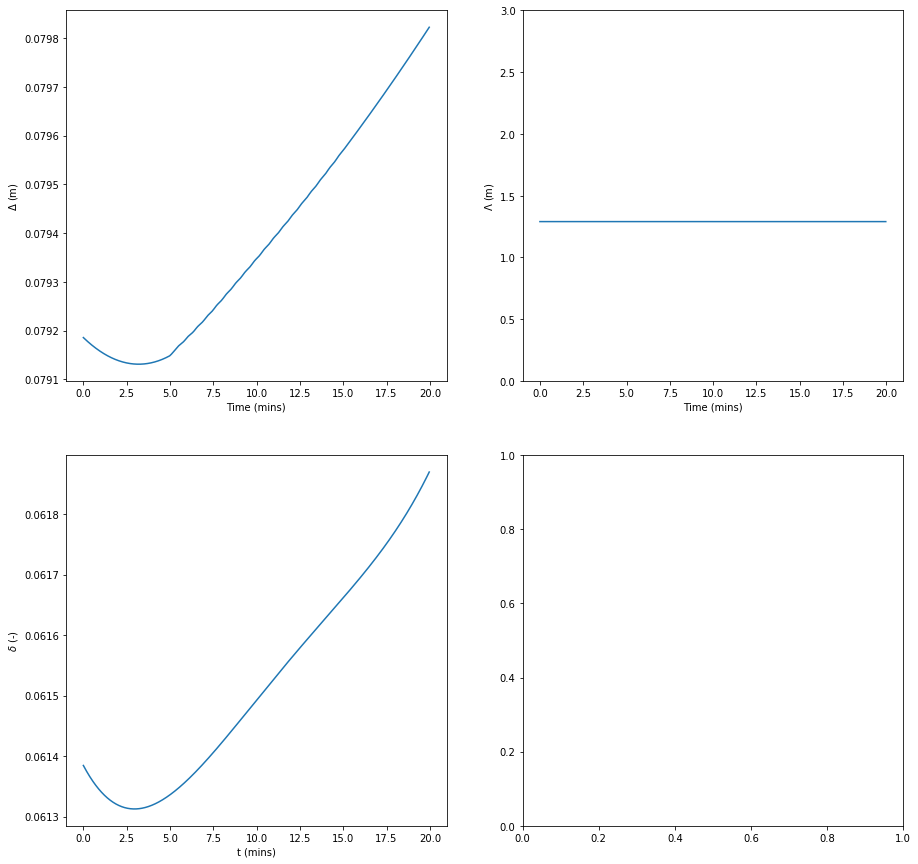

In [70]:

dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

In [67]:
def calculate_wave_speed(verts, dx, dt, step_index = 40, base_index = 1):
    last_peak_index = None
    velocities = []
    timesteps = []
    
    
    for t in range(0, (verts.shape[0]), step_index):
        current_z = verts[t,:,1]
        peaks, _ = post.find_peaks(current_z, height = current_z.mean()*0.8, distance = int(1.2/dx))
        print(peaks, t)
        if last_peak_index is not None:
            delta = peaks[base_index] - last_peak_index[base_index]
            print(delta)
            if delta == 0:
                t += step_index
            if delta > 0:
                velocities.append(delta*dx/(dt*step_index))
            else:
                velocities.append(velocities[len(velocities)-1])
            
            timesteps.append( dt * t )
            #print(delta, delta*dx/(dt*step_index), dt * t)
        last_peak_index = peaks
    return velocities, timesteps

In [72]:
calculate_wave_speed(verts, dx, dt, step_index = 20, base_index = 2)

[ 280  428  577  725  874 1022] 0
[ 280  429  577  726  874 1023] 20
0


IndexError: list index out of range

In [46]:
current_z = verts[10,:,1]
peaks, _ = post.find_peaks(current_z, height = current_z.mean()*0.8, distance = int(1.2/dx))

In [56]:
verts.shape

(1199, 1200, 6)